In [ ]:
#default_exp core.models

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

from vase.config import DATA_PATH
from vase.core.utils import rec_likelihood, kl_div_stdnorm

In [ ]:
#hide
from vase.core.datasets.moving_mnist import MovingMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Models
> Pytorch Models used for encoders, decoders, and classifiers. See Section A.1 of [Aachille et al.](https://arxiv.org/pdf/1808.06508.pdf) for details

In [ ]:
#hide 
from vase.core.datasets.moving_mnist import MovingMNIST, CommonMNIST

In [ ]:
#hide
batch_size = 128
latents = 24
max_environments = 30
moving_mnist = MovingMNIST(DATA_PATH, transform=ToTensor())
mnist = CommonMNIST(DATA_PATH, transform=ToTensor())
mm_loader = DataLoader(moving_mnist, batch_size)
mnist_loader = DataLoader(mnist, batch_size)

mm_batch, _, _= iter(mm_loader).next()
mnist_batch, _ = iter(mnist_loader).next()

## Encoders


### Encoder Architecture From Paper

In [ ]:
#export
class Encoder(nn.Module):
    def __init__(self, latents=10):
        super().__init__()
        self.latents = latents
        #NOTE: no pooling? should compare results with and without
        self.conv1 = nn.Conv2d(1, 64, (4,4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, (4,4), 2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, (4,4), 2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, (4,4), 2, padding=1)
        self.linear = nn.Linear(2048, 256)
        self.linear_mu = nn.Linear(256, self.latents)
        self.linear_logvar = nn.Linear(256, self.latents)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Returns mean and standard deviation to parameterize sigmoid, 
        and final layer to compute environment
        """
        x = self.relu(self.conv1(x)) # (batch_size, 64, 32, 32)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 16, 16)
        x = self.relu(self.conv3(x)) # (batch_size, 128, 8, 8)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 4, 4)
        x = x.reshape(-1, 2048)
        final = self.relu(self.linear(x))
        mu = self.linear_mu(final)
        logvar = self.linear_logvar(final)
        return mu, logvar, final.detach() #detach to prevent gradient flow

In [ ]:
encoder = Encoder(latents=latents)

In [ ]:
mu, sigma, final = encoder(mm_batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

### FC Encoder

In [ ]:
#export
class FCEncoder(nn.Module):
    def __init__(self, latents: int):
        super().__init__()
        self.latents = latents
        self.latents = latents
        self.linear1 = nn.Linear(784, 50)
        self.linear_mu = nn.Linear(50, latents)
        self.linear_logvar = nn.Linear(50, latents)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = x.reshape(-1, 784)
        final = self.act(self.linear1(x))
        mu = self.linear_mu(final)
        logvar = self.linear_logvar(final) #TODO: should this be exponentiated?
        return mu, logvar, final

In [ ]:
fc_encoder = FCEncoder(latents=latents)

In [ ]:
mu, sigma, final = fc_encoder(mnist_batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

## Environmental Inference Network
NOTE: not sure if this receives the $\mu$'s or the layer before the $\mu's$ - I think the layer before?

Section A.1: "We attach an additional fully connected layer to the last layer of the encoder (gradients to the encoder are stopped)."

In [ ]:
#export
class EnvironmentInference(nn.Module):
    def __init__(self, max_environmnets: int, input_dim:int):
        super().__init__()
        self.max_environments = max_environmnets
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, max_environmnets)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, final_latent):
        x = self.linear(final_latent)
        return self.softmax(x)

In [ ]:
_, _, final = encoder(mm_batch)

In [ ]:
env_inf = EnvironmentInference(max_environmnets=max_environments, input_dim=256)
env_dist = env_inf(final)

In [ ]:
assert env_dist.shape == torch.Size([batch_size, max_environments])

In [ ]:
env_dist.sum(dim=1).shape

torch.Size([128])

In [ ]:
assert torch.all(torch.isclose(env_dist.sum(dim=1), torch.ones(128)))

### Environmental  Encoding

See "Environment index" in section A.2 - softmax is averaged across data in batch, then argmax is taken

In [ ]:
avg_env_dist = env_dist.mean(dim=0)

In [ ]:
assert avg_env_dist.shape == torch.Size((max_environments,))

In [ ]:
env_idx = torch.argmax(avg_env_dist)
env_idx

tensor(20)

In [ ]:
F.one_hot(env_idx, num_classes=max_environments)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [ ]:
#export
def env_dist_to_idx(env_dist: torch.Tensor, max_environments: int) -> torch.Tensor:
    """Converts a batch of distributions to a one-hot vector"""
    batch_size = env_dist.shape[0]
    avg_env_dist = env_dist.mean(dim=0)
    env_idx = torch.argmax(avg_env_dist)
    return torch.ones((batch_size), dtype=torch.int64) * env_idx


In [ ]:
_, _, final = encoder(mm_batch)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)

In [ ]:
assert env_idx.shape == torch.Size([batch_size])
assert env_idx[0].dtype == torch.int64

## Decoder

### Decoder Architecture From Paper

In [ ]:
#export
class Decoder(nn.Module):
    def __init__(self, latents:int, max_envs=0):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear2 = nn.Linear(latents + max_envs, 256)
        self.linear1 = nn.Linear(256, 2048)
        self.conv4 = nn.ConvTranspose2d(128, 128, (4,4), 2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, (4,4), 2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 64, (4,4), 2, padding=1)
        self.conv1 = nn.ConvTranspose2d(64, 1, (4,4), 2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tensor): environment indicies (not one hot)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        
        if s is not None:
            s_one_hot = F.one_hot(s, num_classes=self.max_envs)
            z = torch.cat((z, s_one_hot), dim=1)
        x = self.relu(self.linear2(z)) # (batch_size, 256)
        x = self.relu(self.linear1(x)) # (batch_size, 512)
        x = x.reshape(-1, 128, 4, 4) # (batch_size, 128, 2, 2)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 6, 6)
        x = self.relu(self.conv3(x)) # (batch_size, 64, 14, 14)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 30, 30) WRONG (should be 31)
        out = self.sigmoid(self.conv1(x))
        return out

In [ ]:
mu, sigma, final = encoder(mm_batch)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
decoder = Decoder(latents=latents, max_envs=max_environments)

In [ ]:
rec_img = decoder(z, s)

In [ ]:
rec_img.shape

torch.Size([128, 1, 64, 64])

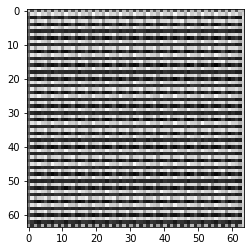

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze(), cmap='gray')

In [ ]:
decoder = Decoder(latents=latents, max_envs=0)

In [ ]:
rec_img = decoder(z, None)

In [ ]:
assert rec_img.shape == torch.Size([batch_size, 1, 64, 64])

### FC Decoder

In [ ]:
#export
class FCDecoder(nn.Module):
    def __init__(self, latents: int, max_envs=0):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear1 = nn.Linear(latents + max_envs, 50)
        self.linear2 = nn.Linear(50, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tensor): one-hot encoded environmental variable (not sure how this works...)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        if s is not None:
            s_one_hot = F.one_hot(s, num_classes=self.max_envs)
            z = torch.cat((z, s_one_hot), dim=1)
        x = self.relu(self.linear1(z))
        x = self.linear2(x)
        out = self.sigmoid(x)
        out = out.reshape(-1, 1, 28, 28)
        return out

In [ ]:
mu, sigma, final = fc_encoder(mnist_batch)
env_inf = EnvironmentInference(max_environmnets=max_environments, input_dim=50)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
fc_decoder = FCDecoder(latents=latents, max_envs=max_environments)

In [ ]:
rec_img = fc_decoder(z, s)

In [ ]:
rec_img.shape

torch.Size([128, 1, 28, 28])

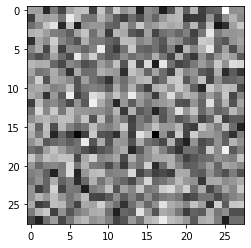

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze(), cmap='gray')

In [ ]:
fc_decoder = FCDecoder(max_envs=0, latents=latents)

In [ ]:
rec_img = fc_decoder(z, None)

In [ ]:
assert rec_img.shape == mnist_batch.shape

## Vanilla VAEs

### Reparameterization Trick

TODO: explain why you have to do this to compute gradients

In [ ]:
#export
def reparam(mu, logvar, device='cpu'):
    eps = torch.randn(logvar.shape).to(device)
    std = (0.5 * logvar).exp()
    return mu + std * eps

### Vanilla VAE (From Paper)

In [ ]:
#export
class VanillaVAE(nn.Module):
    def __init__(self, encoder: type, decoder: type, latents: int, device: str):
        super().__init__()
        self.encoder = encoder(latents=latents)
        self.decoder = decoder(latents=latents)
        self.device = device
        
    def forward(self, x):
        mu, logvar, _final = self.encoder(x)
        if self.training:
            z = reparam(mu, logvar, device=self.device)
        else:
            z = mu
        rec_img = self.decoder(z=z)
        return rec_img, mu, logvar

In [ ]:
#export
class PaperVanillaVAE(VanillaVAE):
    def __init__(self, latents: int, device:str):
        super().__init__(encoder=Encoder, decoder=Decoder, latents=latents, device=device)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
vvae = PaperVanillaVAE(latents=latents, device=device)

In [ ]:
rec_img, mu, logvar = vvae(mm_batch)

In [ ]:
vvae.decoder

Decoder(
  (linear2): Linear(in_features=24, out_features=256, bias=True)
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
rec_img.shape

torch.Size([128, 1, 64, 64])

In [ ]:
assert rec_img.shape == mm_batch.shape

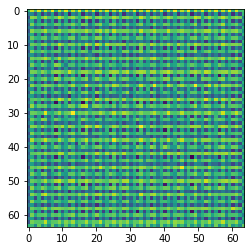

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze())

In [ ]:
assert mu.shape == torch.Size([batch_size, latents])
assert logvar.shape == torch.Size([batch_size, latents])

In [ ]:
vvae.eval()


PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=24, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=24, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=24, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), p

In [ ]:
assert not vvae.training

In [ ]:
rec_img, mu, logvar = vvae(mm_batch)

In [ ]:
rec_img_decode = vvae.decoder(mu)

In [ ]:
assert torch.equal(rec_img, rec_img_decode)

### FC Vanilla VAE

In [ ]:
#export
class FCVAE(VanillaVAE):
    def __init__(self, latents: int, device='cpu'):
        super().__init__(encoder=FCEncoder, decoder=FCDecoder, latents=latents, device=device)
        

In [ ]:
fc_vae = FCVAE(latents=latents)

In [ ]:
rec_img, _, _ = fc_vae(mnist_batch)

In [ ]:
assert rec_img.shape == mnist_batch.shape

## Latent Masking VAEs

The paper introduces latent masking for three reasons:
1. Help with Environmental Inference
2. Promote cross-domain homologies 
3. Prevent Catestrophic forgetting 
Latent masking is performed as follows: if the kl divergence between a latent and the standard normal prior passes some threshold $\lambda$ the the latent is masked (its value is set to 0). More formally:

$$ \alpha_n = KL(E_{x^{s}_{batch}}[q_{\phi}(z^s_n|x^s_{batch})] || p(z_n)) $$

$$\alpha_n = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } \alpha_n < \lambda \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

(TODO: this makes me confused about the C parameter - if the c difference is taken element wise, then the KL divergence is going to be a lot higher (~C), but the $\lambda$ values in the paper range from 0 to 1 - so probably C is the sum over the batch, perhaps with C divided by batch size?)

Rather then estimate the KL divergence of each individual sample, the paper takes the mean and standard deviation of the distribution of latent samples in the batch:

$$ \frac{1}{B} \sum_{b=1}^{B} q_{\phi}(z_n|x_b) $$
fit a gaussian to this distribution, and then take the KL divergence of this fitted distribution

Don't understand the appendix on the threshold ranges, ignoring for now

### Exploration

In [ ]:
latents = 8
batch_size = 128

In [ ]:
fc_vae = FCVAE(latents=latents)

In [ ]:
mu, logvar, _final = fc_vae.encoder(mnist_batch)
z = reparam(mu, logvar)

In [ ]:
z.shape

torch.Size([128, 8])

In [ ]:
lam = .5

In [ ]:
std, mean = torch.std_mean(z, dim=0)
logvar = torch.log(std.pow(2))
mean = mean[:,None]
logvar = logvar[:,None]

In [ ]:
assert mean.shape == torch.Size([latents, 1])
assert logvar.shape == torch.Size([latents, 1])

In [ ]:
alphas = kl_div_stdnorm(mean, logvar)
a = alphas < lam

In [ ]:
assert torch.all(a)

In [ ]:
assert alphas.shape == torch.Size([latents])
assert a.shape == torch.Size([latents])

### Latent Masking VAE


$$\bar{z}_n = \frac{1}{B} \sum_{b=1}^{B} q_{\phi}(z_n|x_b)$$


In [ ]:
#export 
def latent_mask(z, lam):
    std, mean = torch.std_mean(z, dim=0)
    std = std[:,None]
    mean = mean[:, None]
    logvar = torch.log(std.pow(2))
    alphas = kl_div_stdnorm(mean, logvar)
    a = alphas < lam
    return a

In [ ]:
a = latent_mask(z, lam)
assert torch.all(a)
assert a.shape == torch.Size([latents])
assert a.dtype == torch.bool

In [ ]:
z[:,~a] = 0

In [ ]:
z = torch.randn((batch_size, latents)) * 5
a = latent_mask(z, lam)

In [ ]:
assert torch.all(~a)

In [ ]:
z.shape

torch.Size([128, 8])

In [ ]:
z[:,~a] = 0
assert torch.equal(z, torch.zeros(z.shape))

In [ ]:
z = torch.randn((batch_size, latents)) * 1.7
a = latent_mask(z, lam)

In [ ]:
masked_z = torch.clone(z)
masked_z[:, ~a] = 0

In [ ]:
# assert not torch.equal(masked_z, z)
# assert torch.equal(masked_z[:, a], z[:,a])
# assert torch.equal(masked_z[:, ~a], torch.zeros([batch_size, torch.sum(~a)]))

In [ ]:
#export 
def apply_mask(a, z):
    masked_z = torch.clone(z)
    masked_z[:, ~a] = 0
    return masked_z

In [ ]:
#export
class LatentMaskVAE(VanillaVAE):
    def __init__(self, encoder: type, decoder: type, latents: int, device: str, lam: float):
        self.lam = lam
        super().__init__(encoder, decoder, latents, device)
        
    def forward(self, x):
        mu, logvar, _final = self.encoder(x)
        if self.training:
            z = reparam(mu, logvar, device=self.device)
        else:
            z = mu
        
        #latent masking
        a = latent_mask(z, self.lam)
        masked_z = apply_mask(a, z)
        
        rec_img = self.decoder(z=masked_z)
        return rec_img, mu, logvar

In [ ]:
lm_vae = LatentMaskVAE(FCEncoder, FCDecoder, latents=latents, device='cpu', lam=lam)

In [ ]:
rec_img, _mu, _logvar = lm_vae(mnist_batch)

In [ ]:
assert rec_img.shape == torch.Size([batch_size, 1, 28, 28])

## Environmental Inference VAE

### Formal Setup

To infer the environment, you take the most likely environment, reconstruct the image conditional on all previously seen enviornments. If the reconstruction loss is below some threshold and the latent mask is the same as it is for that environment typically, then it is classified as that environment. Else it is classified as a new environment:

$$s = \left\{ 
  \begin{array}{ c l }
    \hat{s} & \quad \textrm{if } E_{z^{\hat{s}}}[p_{\theta}(x^{s}_{batch}|z^{\hat{s}, \hat{s}})] \leq \kappa L_{\hat{s}} \land a^s = a^{\hat{s}} \\
    s_{r+t}                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

Where $\hat{s} = \argmax_{s} q(s|x^s_{batch})$ is the output of the auxiliary classifier trained to output the most likely environment, $L_{\hat{s}}$ is the average reconstruction loss on $\hat{s}$ previously, and $\kappa$ is a hyper parameter.

Also note that the comparision $a^s = a^{\hat{s}}$ is only taken on "used" latent variables. To calculate whether a variable $z_n$ is used, the paper finds the maximum amount of noise to add to $z_n$ without changing the reconstruction performance of the network, solving the following optimization problem:

$$\Sigma = \argmin_{\Sigma = \textrm{diag}(\sigma_1, ..., \sigma_N)} E_{\epsilon \sim \mathcal{N}(0, \sigma)}[-\log(p_{\theta}(x|z^{\epsilon}, s)] - log|\Sigma|$$

with $z^{\epsilon}_n = (1 - \delta_{nm})z_n + \delta_{nm}(z_n + \epsilon)$. We then define the mask $u^s$ as

$$ u_n^s = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } \sigma_n' < T \\
    0                & \quad \textrm{otherwise}
  \end{array}
\right.$$

Three possible methods:
1. actually just do SGD - I'll start with this, but it seems prohibitely slow to do sgd in every batch of this process? idk I guess you only have 24 parameters...
2. Some special solver that does it faster
3. Prescify some discrete set or something
So I guess we could just take a discrete set for each variable ([0,1,2,3,4,5] or something), calculate the loss 




The enviornment detector itself is trained to predict the current enviornment from the current data, and past enviornments using past data. Formally, this loss function is given by:

$$\mathcal{L}_{\textrm{env}} = E_{x}[-log(q_{\psi}(\hat{s}|x))] + E_{\hat{s} \neq s <m} E_{x' \sim p_{\theta'}(x'|z',s)}[-\log q_{\psi}(s|x')]$$

(Note that expected negative likelihood is just cross entropy loss). Past environments are sampled using monte-carlo methods. No mention of optimizer used for environmental classifier (I think this is maximized with the rest of of the model even though gradients are stopped)

Putting it all together, we have:

![enf_inf_alg](assets/env_inf_alg.png)

Note that this algorithm doesn't use the auxilary environmental inference network - rather it performs [analysis by synthesis](https://arxiv.org/abs/1805.09190), determing the environment by seeing which best fits the data. I like this approach better, and it doesn't seem less efficient? The auxilary network requires _more_ generation to prevent catastrophic forgetting 
Other details:
  max_envs = 7

### Environment Inference

In [ ]:
#export
class EnvInferVAE(nn.Module):
    def __init__(self, encoder: type, decoder: type, latents: int, max_envs: int, lam: float, kappa: float, device: str):
        super().__init__()
        self.latents = latents
        self.m = 0
        self.max_envs = max_envs
        self.lam = lam
        self.kappa = kappa
        self.env_count = [0] * self.max_envs
        self.rec_loss_avgs = []
        self.latent_masks = []
        self.used_masks = []
        self.encoder = encoder(latents=latents)
        self.decoder = decoder(latents=latents, max_envs=max_envs)
        self.device = device
        
    def forward(self, x):
        batch_size = x.shape[0]
        mu, logvar, _final = self.encoder(x)
        if self.training:
            z = reparam(mu, logvar, device=self.device)
        else:
            z = mu
        
        #latent masking
        a = latent_mask(z, self.lam)
        masked_z = apply_mask(a, z)

        #infer environment
        env_idx = self.infer_env(x, z, a, masked_z)
        s = torch.ones(batch_size, dtype=torch.int64) * env_idx
        
        rec_img = self.decoder(z=masked_z, s=s)
        return rec_img, mu, logvar, env_idx
    
    def infer_env(self, x, z, a, masked_z):
        # u = model.used(z)
        batch_size = x.shape[0]

        #get maximum likelihood environment using "analysis by synthesis"
        losses = []
        for s_i in range(self.m+1):
            s = torch.ones(batch_size, dtype=torch.int64) * s_i
            with torch.no_grad():
                x_rec = self.decoder(masked_z, s)
                losses.append(torch.sum(rec_likelihood(x, x_rec)))
        env_idx = torch.argmin(torch.tensor(losses))
        
        rec_loss = losses[env_idx]
        avg_rec_loss = rec_loss / batch_size

        if self.env_count[0] == 0:
            self.env_count[self.m] += batch_size
            self.latent_masks.append(a)
            self.rec_loss_avgs.append(avg_rec_loss)
            return self.m
        elif (avg_rec_loss > self.kappa * self.rec_loss_avgs[env_idx] or not torch.equal(a, self.latent_masks[env_idx])) and self.m < self.max_envs-1:
            if avg_rec_loss > self.kappa * self.rec_loss_avgs[env_idx]:
                print("New environment: anomolous reconstruction loss")
            else:
                print("New environment: latent masks did not match")
            self.m += 1
            self.env_count[self.m] += batch_size
            self.latent_masks.append(a)
            self.rec_loss_avgs.append(avg_rec_loss)
            return self.m
        else:
            #TODO add warning about exceeding max envs or something
            self.env_count[env_idx] += batch_size
            n = self.env_count[env_idx]
            m = batch_size
            self.rec_loss_avgs[env_idx] = self.rec_loss_avgs[env_idx] * ((n-m)/n) + rec_loss/n #cumulative average
            return env_idx

In [ ]:
envinfer_vae = EnvInferVAE(FCEncoder, FCDecoder, 8, 7, lam=0.6, kappa=1.5, device='cpu')

In [ ]:
rec_img, mu, logvar, env_idx = envinfer_vae(mnist_batch)

In [ ]:
assert rec_img.shape == torch.Size([batch_size, 1, 28, 28])

In [ ]:
envinfer_vae = EnvInferVAE(Encoder, Decoder, 8, 7, lam=0.6, kappa=1.5, device='cpu')

In [ ]:
rec_img, mu, logvar, env_idx = envinfer_vae(mm_batch)

In [ ]:
assert rec_img.shape == torch.Size([128, 1, 64, 64])

###

## Generative Replay VAE

### Generative Sampling
We need to sample the latents and environments independantly (because the environemt is typically determined by the reconstruction loss, which we don't have access to when sampling, because there is no ground truth image)

In [ ]:
 torch.randn(size=(1,2))

tensor([[-1.0824,  1.7025]])

In [ ]:
s = torch.randint(0, 3, (64,))

In [ ]:
s_one_hot = F.one_hot(s, num_c)
s_one_hot.shape

NameError: name 'num_c' is not defined

In [ ]:
#export
def generate_samples(vae: EnvInferVAE, batch_size: int):
    z = torch.randn(size=(batch_size, vae.latents))
    s = torch.randint(0, vae.m+1, (batch_size,))
    s_one_hot = F.one_hot(s, num_classes=vae.m+1)
    x_sample = vae.decoder(z, s_one_hot)
    return x_sample

In [ ]:
samples = generate_samples(envinfer_vae, 128)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x9 and 15x256)

In [ ]:
#on each batch
    #sample environment
    #sample latent
    #apply environmental mask to latent?

## Classifiers and Regressors